In [1]:
!pip install git+https://github.com/chaithyagr/fastmri-reproducible-benchmark@patch-1 silence-tensorflow python-pysap pysap-mri

  Cloning https://github.com/chaithyagr/fastmri-reproducible-benchmark (to revision patch-1) to /tmp/pip-req-build-jszwi1d0
  Running command git clone --filter=blob:none --quiet https://github.com/chaithyagr/fastmri-reproducible-benchmark /tmp/pip-req-build-jszwi1d0
  Running command git checkout -b patch-1 --track origin/patch-1
  Switched to a new branch 'patch-1'
  Branch 'patch-1' set up to track remote branch 'patch-1' from 'origin'.
  Resolved https://github.com/chaithyagr/fastmri-reproducible-benchmark to commit 7f9761e0c17cde428bd48f1b1201dc98cfd07355
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━

# MRI Reconstruction: a comparison between classical and learning approaches

In this notebook we will compare 3 techniques for reconstructing MRI images:
- the Cascade-net [[1]](#ref1);
- the UPDNet, a U-net-based version of the XPNDet [[2]](#ref2);
- the classical, wavelet-based, iterative reconstruction.

[1] <a id='ref1'></a> Schlemper, J., Caballero, J., Hajnal, J. V, Price, A., & Rueckert, D. (2018). A Deep Cascade of Convolutional Neural Networks for MR Image Reconstruction. IEEE Transactions on Medical Imaging, 37(2), 491–503. https://doi.org/10.1109/TMI.2017.2760978

[2] <a id='ref2'></a> Ramzi Z., Ciuciu P., and Starck J.-L., “XPDNet for MRI Reconstruction: an application to the 2020 fastMRI challenge,” in ISMRM, 2021, pp. 1–4., https://arxiv.org/abs/2010.07290

# A bit of context
MRI stands for Magnetic Resonance Imaging.
It is a medical imaging modality that is used to probe soft tissues inside the human body non-invasively and without the use of ionizing radiations.

However, MRI is particularly slow because it relies on the Magnetic Resonance phenomenon, which is inherently slow.
One way to speed up MRI is to acquire fewer signals (k-space shots ${\bf y}$), i.e. undersample.
If we do that, we find ourselves in a situation where we have not enough signals to reconstruct the image using simply the Inverse Fourier Transform ($F^{-1}$) as is typically done.
In fact, we have an ill-posed inverse problem that one must solve using priors on the MR images ${\bf x}$.

$$
F_{\Omega}{\bf x} = {\bf y}
$$

where $F_{\Omega}$ is a masked Fourier Transform with a mask $\Omega$ that selects the sampled lines in the k-space.

This means that we need a function to tell apart all the possible solutions of the inverse problem, that tells which solution is more likely to be an MR image.

In classical Compressed Sensing, these priors are handcrafted.
Deep Learning allows us to learn these priors from data.

Small note on requirements: run [postBuild](../postBuild) (i.e. `bash postBuild`) to install `pysap-mri` if not running this notebook in binder.

In [1]:
%matplotlib inline
%env TF_CPP_MIN_LOG_LEVEL=3
import warnings
warnings.filterwarnings("ignore")

from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
from mri.operators import FFT, WaveletN
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SingleChannelReconstructor
from modopt.opt.proximity import SparseThreshold
from modopt.opt.linear import Identity
import numpy as np
import tensorflow as tf


import io
import requests

from fastmri_recon.data.utils.crop import crop_center
from fastmri_recon.data.utils.masking.gen_mask import gen_mask
from fastmri_recon.evaluate.metrics.np_metrics import psnr, ssim
from fastmri_recon.models.functional_models.cascading import cascade_net
from fastmri_recon.models.subclassed_models.updnet import UPDNet

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 6

In [3]:
np.random.seed(0)

## Outline

In this notebook, we will [load the data](#data), [retrospectively undersample it](#undersample), and then reconstruct it using 3 methods: the [Cascade-Net](#cascade), the [UPDNet](#updnet) and [wavelet-based compressed sensing with FISTA](#cs) using the [pysap-mri package](https://github.com/CEA-COSMIC/pysap-mri).

# Data handling <a id='data'></a>

The data comes from the fastMRI database [[3]](#ref3). We selected the 16th slice of the first validation file (`file1000000`).

This image was not used when training the pretrained models we use in this demo notebook.

[3] <a id='ref3'></a> Zbontar, J., Knoll, F., Sriram, A., Muckley, M. J., Bruno, M., Defazio, A., … Lui, Y. W. (n.d.). fastMRI: An Open Dataset and Benchmarks for Accelerated MRI. Retrieved from https://arxiv.org/pdf/1811.08839.pdf

## Data loading

In [4]:
image = np.load(io.BytesIO(requests.get('https://github.com/zaccharieramzi/fastmri-reproducible-benchmark/raw/master/examples/gt_image.npy').content), allow_pickle=True)
kspace = np.load(io.BytesIO(requests.get('https://github.com/zaccharieramzi/fastmri-reproducible-benchmark/raw/master/examples/gt_kspace.npy').content), allow_pickle=True)

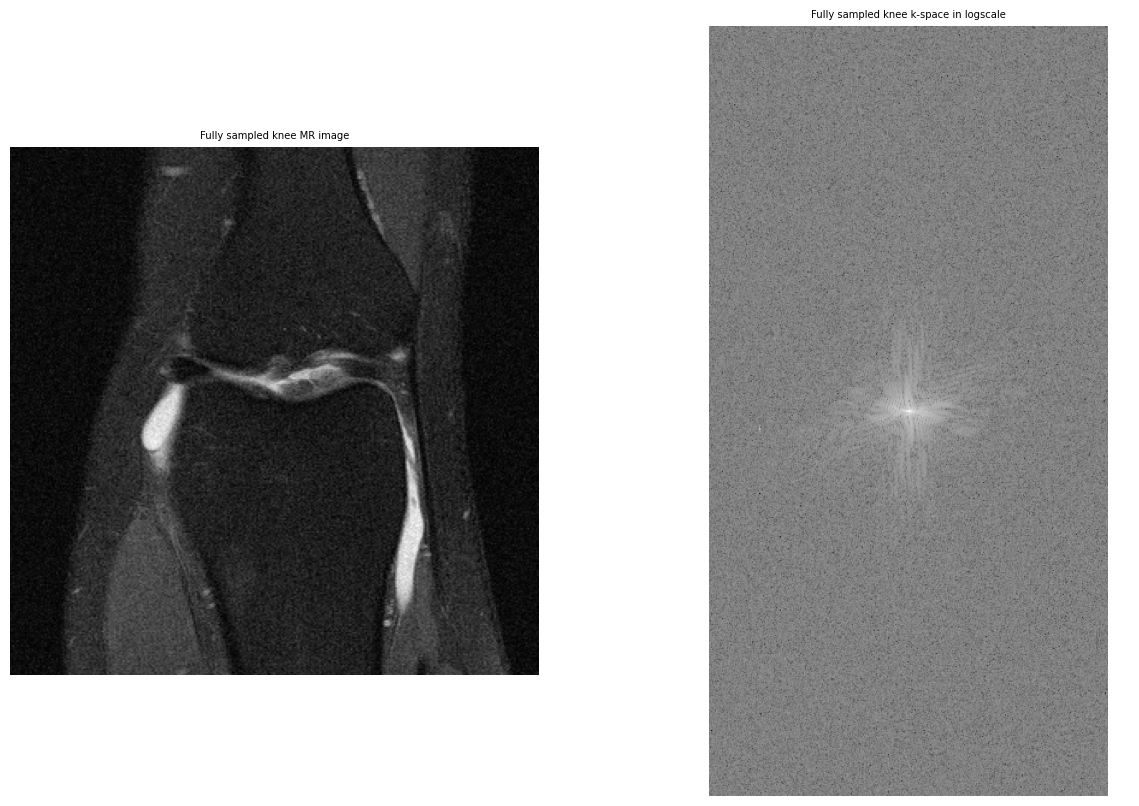

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee MR image')
axs[1].imshow(np.log(np.abs(kspace[..., 0])))
axs[1].set_title('Fully sampled knee k-space in logscale')
for i in [0, 1]:
    axs[i].axis('off');

## Retrospective undersampling <a id='undersample'></a>

In order to compare different reconstruction algorithms, i.e. algorithms that generate an MR image from undersampled data, we will simulate the acquisition of undersampled data via a retrospective undersampling.

In practice, this means that we multiply the original k-space by a binary mask in which the 1 entries correspond to the sampled points in the k-space and the 0 entries correspond to the non-sampled points.

In [15]:
AF = 4
mask = gen_mask(kspace[..., 0], accel_factor=AF, seed=0)
# the mas is received in fastmri format, we make a 1 and 0 mask in the fourier space
fourier_mask = np.repeat(mask.astype(np.float64), kspace.shape[0], axis=0)
masked_kspace = fourier_mask[..., None] * kspace

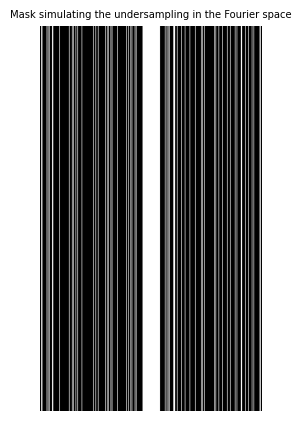

In [16]:
plt.figure()
plt.imshow(fourier_mask)
plt.axis('off')
plt.title('Mask simulating the undersampling in the Fourier space');

If one applies the Inverse Fourier Transform directly on the undersampled data, i.e. the masked out k-space, one obtains an aliased image.

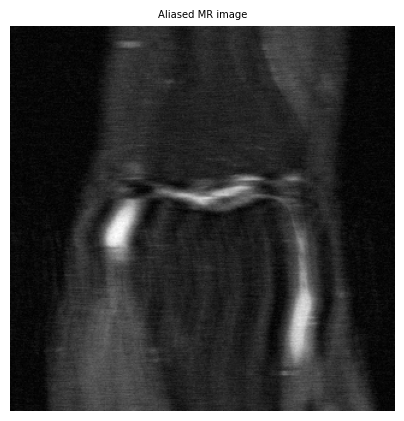

In [17]:
plt.figure()
plt.imshow(crop_center(np.abs(np.fft.fftshift(np.fft.ifft2(masked_kspace[..., 0], norm='ortho'))), 320))
plt.axis('off')
plt.title('Aliased MR image');

## Batching

Batching is necessary when using neural networks on both the training and the prediction steps.

In [18]:
mask_batch = fourier_mask[None, ...]
masked_kspace_batch = masked_kspace[None, ...]

## Scaling
Scaling was used for training to avoid numerical approximations that lead to poor training. Generally the inputs are normalized, but it was easier here to just scale them using the mean over the training set.

In [19]:
masked_kspace_batch *= 1e6  # 1e6 is the mean over the training set of the absolute kspace values.

# Reconstruction using the Cascade-net <a id='cascade'></a>

## Model loading

This model was trained on the [fastMRI 2D knee single coil dataset](https://fastmri.org/dataset/) with [the cascade-net training script from this repo](../fastmri_recon/training_scripts/single_coil/cascadenet_approach_af4.py).

In [20]:
run_params = {
    'n_cascade': 5,
    'n_convs': 5,
    'n_filters': 48,
    'noiseless': True,
}
model_name = 'CascadeNet-fastmri'

In [21]:
model = cascade_net(input_size=(None, None, 1), fastmri=True, **run_params)
model_weights_path = hf_hub_download(
    repo_id=f'zaccharieramzi/{model_name}',
    filename='model_weights.h5',
)
model.load_weights(model_weights_path)

## Reconstruction

In [22]:
%%time
cascade_reconstructed_image = model.predict_on_batch([masked_kspace_batch, mask_batch])

CPU times: user 9.67 s, sys: 1.2 s, total: 10.9 s
Wall time: 6.73 s


## Visual comparison

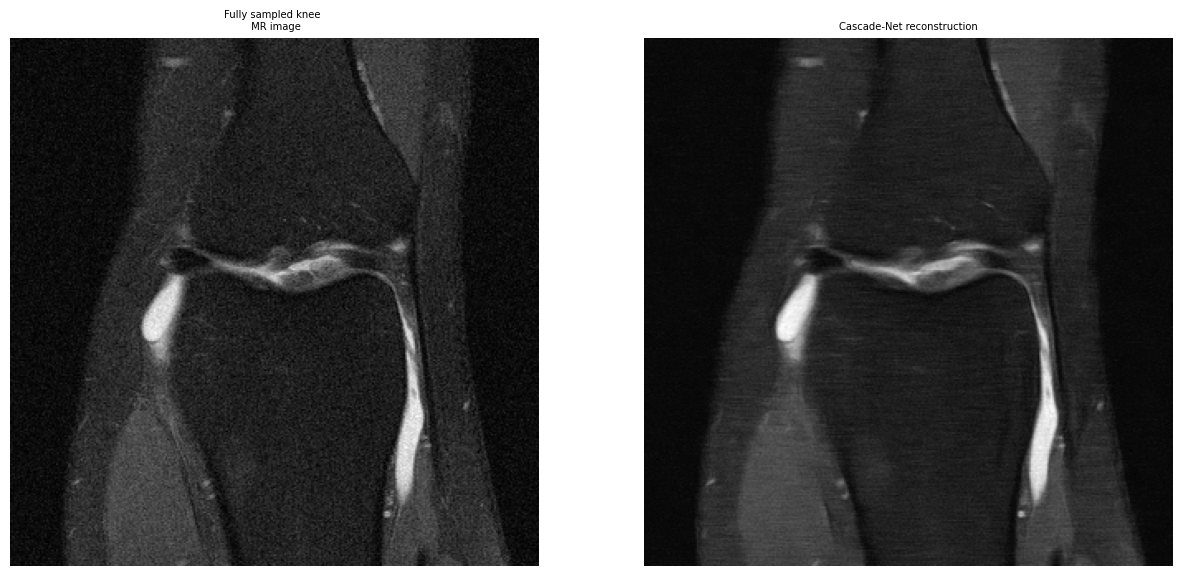

In [23]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 10))
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee \n MR image')
axs[1].imshow(cascade_reconstructed_image[0, ..., 0])
axs[1].set_title('Cascade-Net reconstruction')
for i in [0, 1]:
    axs[i].axis('off')

## Quantitative comparison

In order to assess the quality of the reconstruction, it is important to have access to quantitative metrics in order to rationalize the process and easily compare methods.
We compute here 2 typical metrics, used in the image processing literature and in particular the fastMRI challenge:
- the [Peak Signal to Noise Ratio (PSNR)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio);
- the [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity).

For these 2 metrics, the higher the better.

In [24]:
print('PSNR of the Cascade-Net reconstructed image:', psnr(image, cascade_reconstructed_image[0]/1e6))

PSNR of the Cascade-Net reconstructed image: 29.292248591114397


In [25]:
print('SSIM of the Cascade-Net reconstructed image:', ssim(image[None, ..., 0], cascade_reconstructed_image[..., 0]/1e6))

SSIM of the Cascade-Net reconstructed image: 0.6164851


## A Better prior <a id='updnet'></a>

We can learn a better prior using the XPDNet models [[2]](#ref2), of which UPDNet is an instance.

This model was trained on the [fastMRI 2D knee single coil dataset](https://fastmri.org/dataset/) with [the updnet training script from this repo](../fastmri_recon/training_scripts/updnet_train.py).

In [26]:
model = UPDNet(
    n_dual=1,
    primal_only=True,
    layers_n_channels=[16 * 2**i for i in range(3)],
)
kspace_size = [1, 320, 320]
inputs = [
    tf.zeros(kspace_size + [1], dtype=tf.complex64),  # kspace
    tf.zeros(kspace_size, dtype=tf.complex64),  # mask
]
model(inputs);

In [27]:
model_name = 'UPDNet-knee-singlecoil-af4'
model_weights_path = hf_hub_download(
    repo_id=f'zaccharieramzi/{model_name}',
    filename='model_weights.h5',
)
model.load_weights(model_weights_path)

model_weights.h5:   0%|          | 0.00/5.00M [00:00<?, ?B/s]

In [28]:
%%time
updnet_reconstructed_image = model.predict_on_batch([
    tf.cast(masked_kspace_batch, tf.complex64),
    mask_batch,
])

CPU times: user 16.3 s, sys: 856 ms, total: 17.2 s
Wall time: 14 s


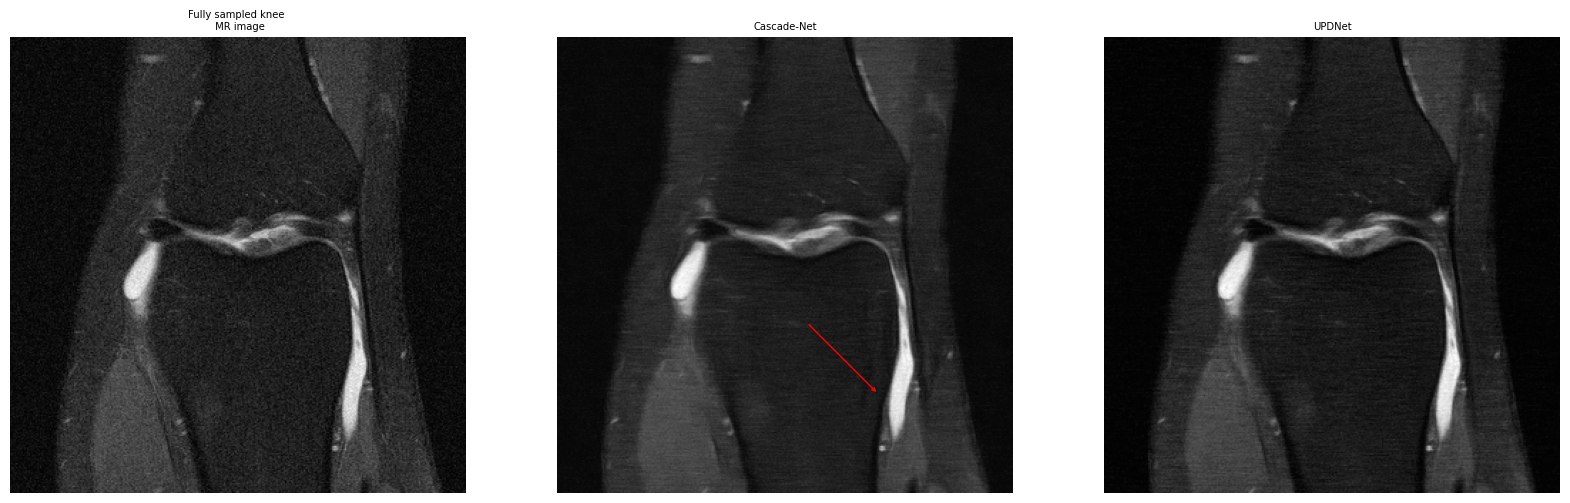

In [29]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, 10))
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee \n MR image')
axs[1].imshow(cascade_reconstructed_image[0, ..., 0])
axs[1].set_title('Cascade-Net')
axs[1].annotate("", xy=(225, 250), xytext=(175, 200),
            arrowprops=dict(arrowstyle="->", color='red'))
axs[2].imshow(updnet_reconstructed_image[0, ..., 0])
axs[2].set_title('UPDNet')
for i in range(3):
    axs[i].axis('off');

A visual inspection shows that the UPDNet is able to reconstruct the image without the artifacts suffered by the Cascade-Net, like the one pointed out by the red arrow.

In [30]:
print('PSNR of the UPDNet reconstructed image:', psnr(image, updnet_reconstructed_image[0]/1e6))

PSNR of the UPDNet reconstructed image: 29.491152398658286


In [31]:
print('SSIM of the UPDNet reconstructed image:', ssim(image[None, ..., 0], updnet_reconstructed_image[..., 0]/1e6))

SSIM of the UPDNet reconstructed image: 0.6394745


Quantitatively, the advantage of the UPDNet over the Cascade-Net is confirmed by the PSNR and SSIM computations.

# Reconstruction using pysap <a id='cs'></a>

In this section we will reconstruct the data using a wavelet-based compressed sensing method, in order to compare it to the deep learning methods.

## Reformatting the data

In [32]:
kspace_squeeze = np.squeeze(kspace*1e6)
k_shape = kspace_squeeze.shape
kspace_loc = convert_mask_to_locations(fourier_mask)

## Creating the appropriate operators

Here a few hyperparameters come into play:
- the type of wavelet to use `wavelet_name`, here sym8;
- the number of scales to use for the wavelet decomposition `nb_scales`, here 4;
- the regularization parameter, here denoted as the threshold, 0.01.

Some other higher level problem setting parameters are the choice of a soft threshold compared to a hard one, and the problem formulation as analysis vs. synthesis (see [[4]](#ref4)).

[4] <a id='ref4'></a> Cherkaoui H. et al., “Analysis vs Synthesis-based Regularization for combined Compressed Sensing and Parallel MRI Reconstruction at 7 Tesla,” 2018. https://hal.inria.fr/hal-01800700v2

In [33]:
fourier_op = FFT(samples=kspace_loc, shape=k_shape)

In [39]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4, padding_mode="periodization")
regularizer_op = SparseThreshold(Identity(), 0.1, thresh_type="soft")
# Setup Reconstructor
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.0999999484895577
The lipschitz constraint is satisfied


## Reconstruction
For the reconstruction we will use the FISTA algorithm

In [40]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_squeeze,
    optimization_alg='fista',
    num_iterations=200,
)
image_rec_fs = crop_center(np.abs(x_final), 320)

 - mu:  0.1
 - lipschitz constant:  1.0999999484895577
 - data:  (640, 368)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fee61b9fac0> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  25.312804519999986  seconds
----------------------------------------


## Visual comparison

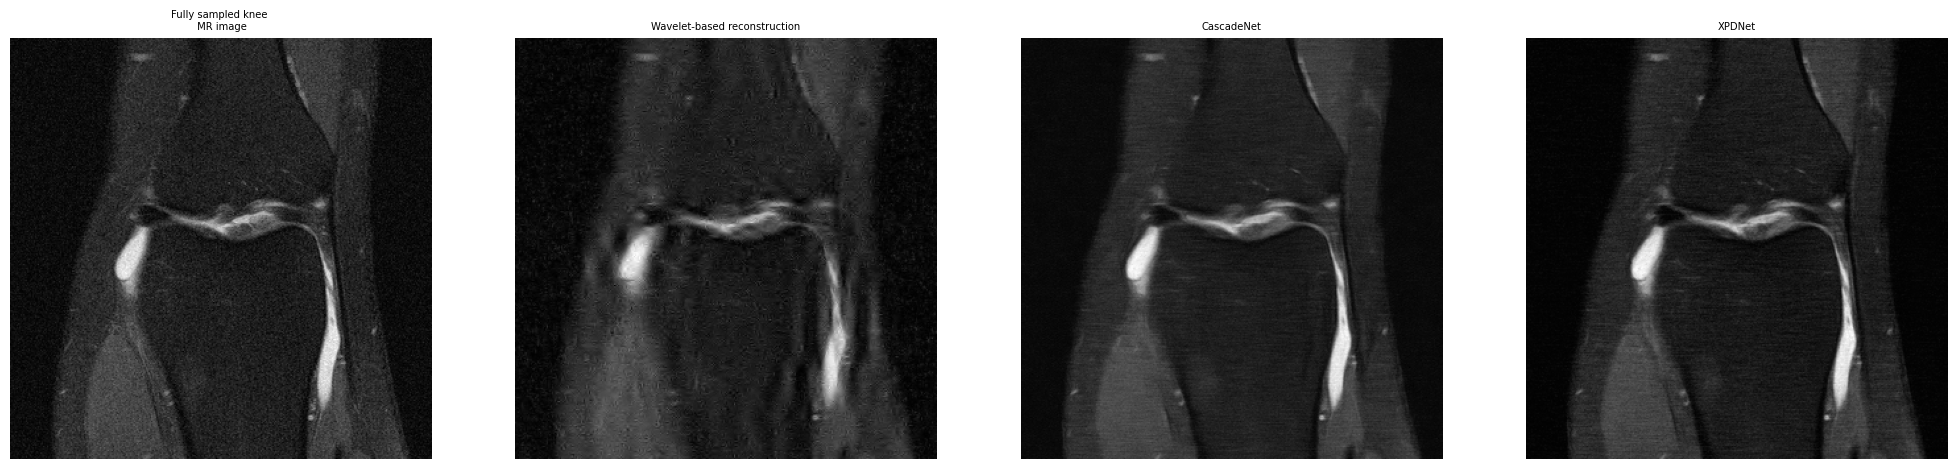

In [41]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(25, 10))
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee \n MR image')
axs[1].imshow(image_rec_fs)
axs[1].set_title('Wavelet-based reconstruction')
axs[2].imshow(cascade_reconstructed_image[0, ..., 0])
axs[2].set_title('CascadeNet')
axs[3].imshow(updnet_reconstructed_image[0, ..., 0])
axs[3].set_title('XPDNet')

for i in range(4):
    axs[i].axis('off');

## Quantitative comparison

In [44]:
print('PSNR of the pysap reconstructed image:', psnr(image[..., 0], image_rec_fs/1e6))

PSNR of the pysap reconstructed image: 25.914059210530226


In [45]:
print('SSIM of the pysap reconstructed image:', ssim(image[None, ..., 0], image_rec_fs[None, ...]/1e6))

SSIM of the pysap reconstructed image: 0.49326524


We can see that both qualitatively and quantitatively the wavelet-based compressed sensing method performs worse than the deep learning methods for a similar computation time on CPU.